# Geometry optimisation calculation

## Run geometry optimisation

To run a geometry optimisation using aiida-mlip you need to define some inputs as AiiDA data types, to then pass to the calculation.

To start, you will need a structure to optimise. 

The structure in the example is NaCl, generated using ase.build, or alternatively one can choose one of the structures in the folder `Structures`.
The input structure in aiida-mlip needs to be saved as a StructureData type.
We can print some properties of the structure, for example the cell or the atoms sites.

In [17]:
from aiida import load_profile
load_profile()

from aiida.orm import StructureData
from ase.io import read
from ase.build import bulk


#structure = StructureData(ase=read("structures/qmof-ffeef76.cif"))
structure = StructureData(ase=bulk("NaCl", "rocksalt", 5.63))

print(f"Initial cell parameters: {structure.cell}")
print(f"Structure's atoms sites: {structure.sites}")

Initial cell parameters: [[0.0, 2.815, 2.815], [2.815, 0.0, 2.815], [2.815, 2.815, 0.0]]
Structure's atoms sites: [<Site: kind name 'Na' @ 0.0,0.0,0.0>, <Site: kind name 'Cl' @ 2.815,0.0,0.0>]


Then we need to choose a model and architecture to be used for the calculation and save it as ModelData type, a specific data type of this plugin.
In this example we use mace_mp with a model that we download from this URL: "https://github.com/stfc/janus-core/raw/main/tests/models/mace_mp_small.model", and we save the file in the cache folder (default="~/.cache/mlips/"):


In [18]:
from aiida_mlip.data.model import ModelData
uri = "https://github.com/stfc/janus-core/raw/main/tests/models/mace_mp_small.model"
model = ModelData.from_uri(uri, architecture="mace_mp", cache_dir="mlips")

If we already have the model saved in some folder we can save it as:

In [19]:
# from aiida_mlip.data.model import ModelData
# model = ModelData.from_local("mlips/mace_mp/mace_mp_small.model", architecture="mace_mp")

Another parameter that we need to define as AiiDA type is the code. Assuming the code is saved as `janus` in the `localhost` computer, the code info that are needed can be loaded as follow:


In [20]:
from aiida.orm import load_code
code = load_code("janus@localhost")

The other inputs can be set up as AiiDA Str, Float or Bool. There is a default for every input except the structure and code. This is a list of possible inputs:

In [ ]:
from aiida.orm import Bool, Dict, Float, Str

inputs = {
        "code": code,
        "model": model,
        "struct": structure,
        "arch": Str(model.architecture),
        "device": Str("cpu"),
        "calc_kwargs": Dict({}),
        "fmax": Float(0.1), 
        "opt_cell_lengths": Bool(False), 
        "opt_cell_fully": Bool(True),
        "pressure" : Float(0.0),
        "minimize_kwargs": Dict({"filter_kwargs": {"constant_volume": True}}),
        "metadata": {"options": {"resources": {"num_machines": 1}}},
    }

It's worth noting that the architecture is already defined within the model, accessible through the architecture property in the ModelData. Even if not explicitly provided as input, it will be automatically retrieved from the model.

The calculation must be set:

In [22]:
from aiida.plugins import CalculationFactory
geomoptCalc = CalculationFactory("mlip.opt")

In this case, since we are running a geometry optimisation the entry point is `mlip.opt`
Finally, run the calculation:


In [23]:
from aiida.engine import run_get_node
result, node = run_get_node(geomoptCalc, **inputs)
print("CALCULATION FINISHED")

CALCULATION FINISHED


## Analyse results

`result` is a dictionary of the available results obtained from the calculation, while node contains the infor on the node where the calculation is run:


In [24]:
print(f"Printing output nodes dictionary: {result}")
print("")
print(f"Printing calcjob node info: {node}")

Printing output nodes dictionary: {'remote_folder': <RemoteData: uuid: 4f990f5d-68be-468d-beab-42bb2a699be8 (pk: 259)>, 'retrieved': <FolderData: uuid: 2f9bc11a-efa2-4ef5-87ce-6351000b1c90 (pk: 260)>, 'log_output': <SinglefileData: uuid: cab7e7d8-00ab-4dcb-825e-32ab4c188732 (pk: 261)>, 'std_output': <SinglefileData: uuid: c175eab1-445c-46e0-89f7-66ea8e2e2444 (pk: 262)>, 'xyz_output': <SinglefileData: uuid: 022a1cc5-29b8-4ea5-9fc5-ea27c64ef5ad (pk: 263)>, 'results_dict': <Dict: uuid: 7d9ef5d3-8437-40d3-b98c-aa2692b3d4a1 (pk: 264)>, 'traj_file': <SinglefileData: uuid: df703541-12cb-42aa-be60-8090b3e340c0 (pk: 265)>, 'traj_output': <TrajectoryData: uuid: 04f7eabb-d5ab-48b9-9f09-00684e792f3c (pk: 266)>, 'final_structure': <StructureData: uuid: 4e1498f8-8abd-4d7c-a174-24f054ab9754 (pk: 267)>}

Printing calcjob node info: uuid: 81dd57a9-b0e7-4190-80d8-dfaf9578864c (pk: 258) (aiida.calculations:mlip.opt)


In this case there are more outputs than the single point calculation, such as the output structure and the trajectory of the optimisation.
We can see how many steps it took to optimise:

In [25]:
print(f"The number of optimisation steps is: {result['traj_output'].numsteps}")

The number of optimisation steps is: 1


The calculation can also be interacted with through verdi cli. Use `verdi process list` to show the list of calculations.


In [26]:
! verdi process list -a

  PK  Created    Process label          ♻    Process State    Process status
----  ---------  ---------------------  ---  ---------------  ----------------
 114  1D ago     Singlepoint                 ⏹ Finished [0]
 132  1D ago     GeomOpt                     ⏹ Finished [0]
 153  1D ago     GeomOpt                     ⏹ Finished [0]
 164  1D ago     prepare_struct_inputs       ⏹ Finished [0]
 170  1D ago     Singlepoint                 ⏹ Finished [0]
 188  1D ago     GeomOpt                     ⏹ Finished [0]
 199  1D ago     prepare_struct_inputs       ⏹ Finished [0]
 205  1D ago     Singlepoint                 ⏹ Finished [0]
 223  1D ago     GeomOpt                     ⏹ Finished [0]
 234  1D ago     prepare_struct_inputs       ⏹ Finished [0]
 240  1D ago     Singlepoint                 ⏹ Finished [0]
 258  12s ago    GeomOpt                     ⏹ Finished [0]

Total results: 12

Report: ♻ Processes marked with check-mark were not run but taken from the cache.
Report: Add the option

The last calculation in the list is the last thing that was run. The PK number should correspond to the PK printed when you printed the node.
You can interact with the data through verdi commands, by writing that PK number of the calculation of interest.
Every calcjob node has a results dictionary which is outputted when running:


In [34]:
! verdi calcjob res 258

defining outputnode
{
    "cell": [
        [
            0.0,
            2.815,
            2.815
        ],
        [
            2.815,
            0.0,
            2.815
        ],
        [
            2.815,
            2.815,
            0.0
        ]
    ],
    "info": {
        "arch": "mace_mp",
        "config_type": "geom_opt",
        "final_spacegroup": "Fm-3m (225)",
        "initial_spacegroup": "Fm-3m (225)",
        "mace_mp_energy": -6.7575203839729,
        "mace_mp_stress": [
            -0.005816546985101,
            -0.005816546985101,
            -0.005816546985101,
            0.0,
            1.1681803864766e-18,
            -2.7247576545301e-18
        ],
        "model": "mlff.model",
        "system_name": "aiida",
        "units": {
            "energy": "eV",
            "forces": "ev/Ang",
            "stress": "ev/Ang^3"
        }
    },
    "mace_mp_forces": [
        [
            0.0,
            -0.0,
            0.0
        ],
        [
         

With the node show command we can see the inputs and outputs of the calculation.

In [35]:
! verdi node show 258

Property     Value
-----------  ------------------------------------
type         GeomOpt
state        Finished [0]
pk           258
uuid         81dd57a9-b0e7-4190-80d8-dfaf9578864c
label
description
ctime        2025-10-03 12:57:52.355553+00:00
mtime        2025-10-03 12:58:03.512893+00:00
computer     [1] localhost

Inputs              PK  Type
----------------  ----  -------------
arch               248  Str
calc_kwargs        250  Dict
code                 1  InstalledCode
device             249  Str
fmax               251  Float
log_filename       255  Str
minimize_kwargs    254  Dict
model              106  ModelData
opt_cell_fully     253  Bool
opt_cell_lengths   252  Bool
out                257  Str
struct             247  StructureData
summary            256  Str

Outputs            PK  Type
---------------  ----  --------------
final_structure   267  StructureData
log_output        261  SinglefileData
remote_folder     259  RemoteData
results_dict      264  Dict
retrieved   

In [36]:
!verdi node show 266

Property     Value
-----------  ------------------------------------
type         TrajectoryData
pk           266
uuid         04f7eabb-d5ab-48b9-9f09-00684e792f3c
label
description
ctime        2025-10-03 12:58:03.194571+00:00
mtime        2025-10-03 12:58:03.445773+00:00


For the geometry optimisation we are most likely interested in the final structure and the trajectory of the geometry optimisation. Let's compare the initial and final cell parameters and see if they changed.

In [29]:
from aiida.orm import load_node

print(f"Initial cell parameters: {structure.cell}")
final_structure = load_node(232)
print(f"Final cell parameters: {final_structure.cell}")

Initial cell parameters: [[0.0, 2.815, 2.815], [2.815, 0.0, 2.815], [2.815, 2.815, 0.0]]
Final cell parameters: [[0.0, 2.815, 2.815], [2.815, 0.0, 2.815], [2.815, 2.815, 0.0]]


## Plot energies and visualise provenance graph

Now let's analyse the steps of the optimisation. We'll run singlepoint calculation on every steps to see how the energy changed. We'll also use this to visualise a complex provenance graph with more calculations connected.
Note the outputs of the calculation can be called either by using the load_node function when the Pk is known or directly with the outputs attribute of the calcjobe node.
Note also that we use the `calcfunction` decorator get the single structures from the `TrajectoryData`

In [30]:
from aiida.orm import load_node
from aiida.engine import calcfunction


traj = node.outputs.traj_output
# traj = load_node(141) 
    
@calcfunction
def prepare_struct_inputs(traj, index):
    return traj.get_step_structure(index.value)

uri = "https://github.com/stfc/janus-core/raw/main/tests/models/mace_mp_small.model"
model = ModelData.from_uri(uri, architecture="mace_mp", cache_dir="mlips")
list_of_nodes = []


inputs = {
    "code": code,
    "model": model,
    "device": Str("cpu"),
    "metadata": {"options": {"resources": {"num_machines": 1}}},
}
    
for index in range(traj.numsteps):
    print(index)
    singlepointCalc = CalculationFactory("mlip.sp")
    struc = prepare_struct_inputs(traj, index)
    inputs['struct']=struc
    result, node = run_get_node(singlepointCalc, **inputs)
    list_of_nodes.append(node)
print("calculations ended")

0
calculations ended


Let's print the list of alcjob nodes that we just created

In [31]:
list_of_nodes

[<CalcJobNode: uuid: 0f4e54b1-8657-4659-9ab2-b0eb25d28d0d (pk: 275) (aiida.calculations:mlip.sp)>]

Now we can use it for getting the energies in every step and plotting them.
(a better alternative to the list of nodes might be to use a AiiDA group, see high-throughput-screening tutorial)

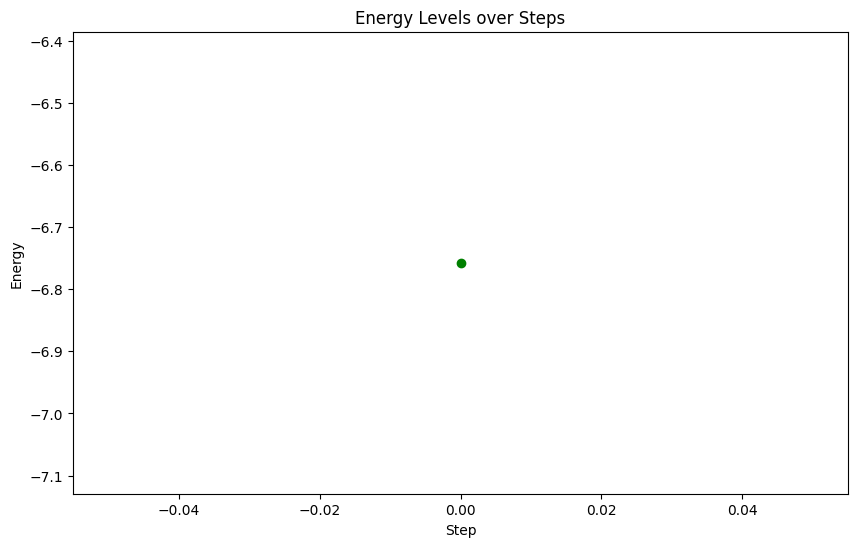

In [32]:
import matplotlib.pyplot as plt

steps = []
energies = []

# Loop through each node to extract step number and energy level
for step, node in enumerate(list_of_nodes):
    energy = node.outputs.results_dict.get_dict()['info']['mace_mp_energy']
    steps.append(step)
    energies.append(energy)

# Plotting the energy levels over steps
plt.figure(figsize=(10, 6))
plt.plot(steps, energies, marker='o', linestyle='-', color='g')
plt.title('Energy Levels over Steps')
plt.xlabel('Step')
plt.ylabel('Energy')
plt.show()


We can see that the energy decreased, which is what we want in a geometry optimisation process.

Now let's generate the provenance graph. (Insert PK number of the TrajectoryData in the code)

In [33]:
! verdi node graph generate 231

Success: Output written to `231.dot.pdf`


The provenance graph shows both the calculation that created the `TrajectoryData` and the calculations that we run using the structures in the `TrajectoryData`.
This is made possible by the use of the `calcfunction` decorator that we used. If we had not used it, the graph would stop a the `TrajectoryData` and the other `Singlepoint` calculations would be independent.